In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import dolfinx as dfx

from dolfinx.fem.petsc import NonlinearProblem

%matplotlib widget
from matplotlib import pyplot as plt
# plt.style.use('fivethirtyeight')

from mpi4py import MPI

import numpy as np

from petsc4py import PETSc

import random

import ufl

from cahn_hilliard_utils import charge_discharge_stop, AnalyzeOCP

from fenicsx_utils import (evaluation_points_and_cells,
                           get_mesh_spacing,
                           time_stepping,
                           NewtonSolver,
                           Fenicx1DOutput)

from plotting_utils import add_arrow

In [3]:
comm_world = MPI.COMM_WORLD

In [4]:
# Set up the mesh

n_elem = 128

mesh = dfx.mesh.create_unit_interval(comm_world, n_elem)

dx_cell = get_mesh_spacing(mesh)

print(f"Cell spacing: h = {dx_cell}")

# For later plotting use
x = np.linspace(0, 1, 101)
points_on_proc, cells = evaluation_points_and_cells(mesh, x)

Cell spacing: h = 0.0078125


In [5]:
elem1 = ufl.FiniteElement("Lagrange", mesh.ufl_cell(), 1)

V = dfx.fem.FunctionSpace(mesh, elem1 * elem1)  # A mixed two-component function space

In [6]:
# The mixed-element functions
u = dfx.fem.Function(V)
u0 = dfx.fem.Function(V)

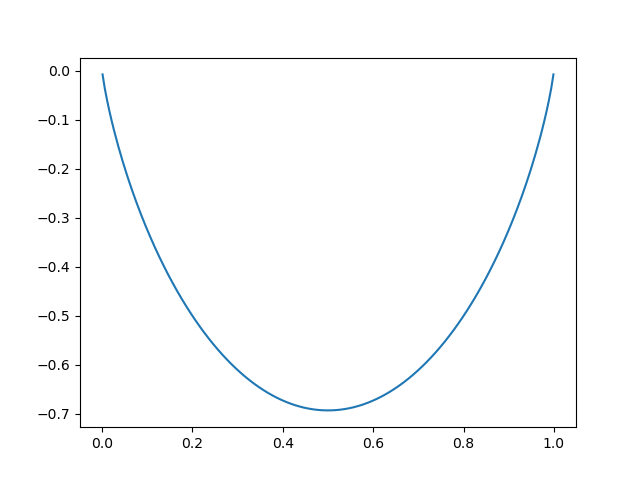

In [7]:
# Compute the chemical potential df/dc

free_energy = lambda c, log: c * log(c) + (1 - c) * log(1 - c)

fig, ax = plt.subplots()

eps = 1e-3

c_plot = np.linspace(eps, 1-eps, 200)

ax.plot(c_plot, free_energy(c_plot, np.log))

plt.show()

In [8]:
c_of_y = lambda y, exp: exp(y) / (1 + exp(y))

In [9]:
# Test the transformation

y_of_c = lambda c, log: log(c / (1 - c))

assert np.allclose(np.abs(c_of_y(y_of_c(c_plot, np.log), np.exp) - c_plot), 0.)

In [10]:
dt = dfx.fem.Constant(mesh, dx_cell * 0.01)

In [11]:
# Experimental setup
# ------------------

# charging current
I_charge = dfx.fem.Constant(mesh, 1.0)

def experiment(t, u, I_charge):

    return charge_discharge_stop(t, u, I_charge, c_of_y=lambda y: c_of_y(y, ufl.exp))

event_params = dict(I_charge=I_charge)

In [12]:
# The variational form
# --------------------
from cahn_hilliard_utils import cahn_hilliard_form

F = cahn_hilliard_form(
    u,
    u0,
    dt,
    free_energy=lambda c: free_energy(c, ufl.ln),
    theta=0.75,
    c_of_y=lambda y: c_of_y(y, ufl.exp),
    M=lambda c: 1. * c * (1 - c),
    lam=0.01,
    **event_params
)

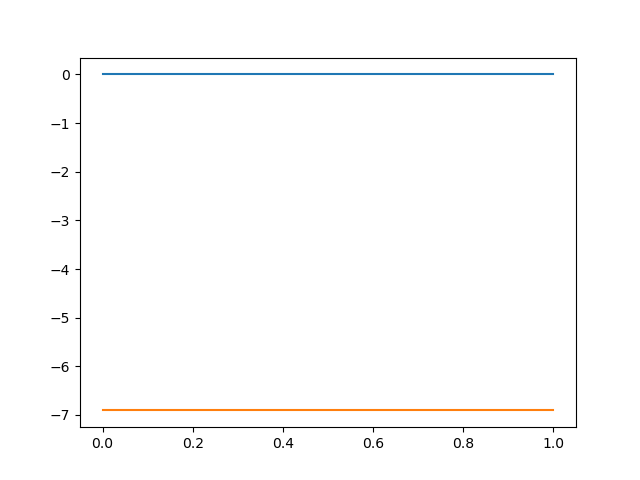

In [13]:
# Initial data
# ------------

u_ini = dfx.fem.Function(V)

# Random
c_ini_fun = lambda x: 0.01 * np.random.randn(*x[0].shape)

# Zero-mean
c_ini_fun = lambda x: np.cos(np.pi * x[0])

# Constant
c_ini_fun = lambda x: eps * np.ones_like(x[0])

# Initial charge distribution.
# c_ini_fun = lambda x: eps + 0.5 * np.sin(np.pi * x[0])


# Store concentration-like quantity into state vector
# ---------------------------------------------------

W = V.sub(1).collapse()[0]
c_ini = dfx.fem.Function(W)
c_ini.interpolate(c_ini_fun)

y_ini = dfx.fem.Expression(y_of_c(c_ini, ufl.ln), W.element.interpolation_points())

u_ini.sub(0).interpolate(y_ini)


# Store chemical potential into state vector
# ------------------------------------------

W = u_ini.sub(1).function_space.element
c_ini = ufl.variable(c_ini)
dFdc = ufl.diff(free_energy(c_ini, ufl.ln), c_ini)

u_ini.sub(1).interpolate(dfx.fem.Expression(dFdc, W.interpolation_points()))

u_ini.x.scatter_forward()

plt.figure()

plt.plot(x, c_of_y(u_ini.sub(0).eval(points_on_proc, cells), np.exp))
plt.plot(x, u_ini.sub(1).eval(points_on_proc, cells))

plt.show()

In [14]:
problem = NonlinearProblem(F, u)

solver = NewtonSolver(comm_world, problem)

In [15]:
T = 10.  # ending time

u.interpolate(u_ini)

n_out = 501

output = Fenicx1DOutput(u, np.linspace(0, T, n_out), x)

rt_analysis = AnalyzeOCP()

time_stepping(
    solver,
    u,
    u0,
    T,
    dt,
    dt_increase=1.01,
    dt_max=1e-3,
    event_handler=experiment,
    output=output,
    runtime_analysis=rt_analysis,
    **event_params,
)

t=0.00000 ; min_c = 1.000e-03 ; max_c = 1.000e-03
t = 0.000078 : dt = 7.891e-05, its = 9
t=0.00008 ; min_c = 1.000e-03 ; max_c = 3.582e-03
>>> Save snapshot [0000] t=0.000
t = 0.000157 : dt = 7.970e-05, its = 6
t=0.00016 ; min_c = 1.000e-03 ; max_c = 5.780e-03
t = 0.000237 : dt = 8.049e-05, its = 5
t=0.00024 ; min_c = 1.000e-03 ; max_c = 7.573e-03
t = 0.000317 : dt = 8.130e-05, its = 5
t=0.00032 ; min_c = 1.000e-03 ; max_c = 9.105e-03
t = 0.000399 : dt = 8.211e-05, its = 5
t=0.00040 ; min_c = 1.000e-03 ; max_c = 1.047e-02
t = 0.000481 : dt = 8.293e-05, its = 5
t=0.00048 ; min_c = 1.000e-03 ; max_c = 1.171e-02
t = 0.000564 : dt = 8.376e-05, its = 5
t=0.00056 ; min_c = 1.000e-03 ; max_c = 1.288e-02
t = 0.000647 : dt = 8.460e-05, its = 5
t=0.00065 ; min_c = 1.000e-03 ; max_c = 1.397e-02
t = 0.000732 : dt = 8.544e-05, its = 5
t=0.00073 ; min_c = 1.000e-03 ; max_c = 1.501e-02
t = 0.000817 : dt = 8.630e-05, its = 4
t=0.00082 ; min_c = 1.000e-03 ; max_c = 1.601e-02
t = 0.000904 : dt = 8.716e-

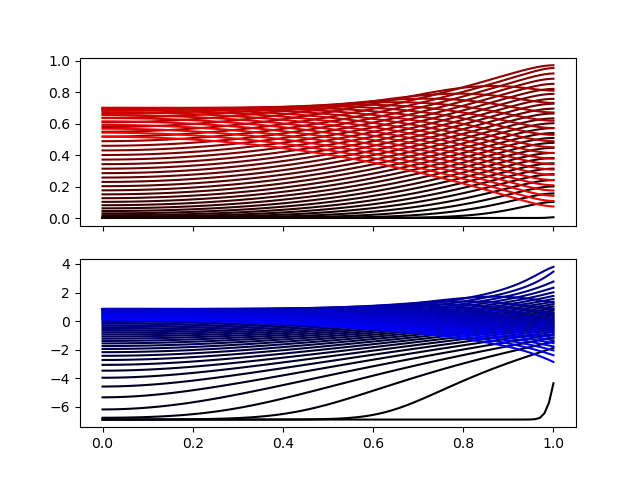

In [16]:
fig, axs = plt.subplots(2, 1, sharex=True)

t_out, data_out = output.get_output(return_time=True)

data_out = np.array(data_out).squeeze()

for it_out, (data_t, t) in enumerate(zip(data_out, t_out)):

    y_t = data_t[0]
    mu_t = data_t[1]

    c_t = c_of_y(y_t, np.exp)

    ax = axs[0]

    color = (it_out / len(t_out), 0, 0)

    ax.plot(x, c_t, color=color)

    ax = axs[1]

    color = (0, 0, it_out / len(t_out))

    ax.plot(x, mu_t, color=color)

plt.show()

interactive(children=(IntSlider(value=0, description='it', max=46), Output()), _dom_classes=('widget-interact'…

<function __main__.update(it=10)>

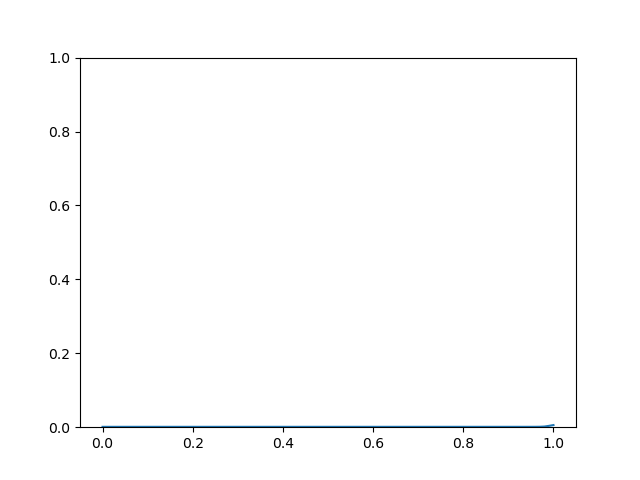

In [17]:
fig, ax = plt.subplots()

line, = ax.plot(x, c_of_y(data_out[0][0], np.exp))

ax.set_ybound(0, 1)

it_max = len(data_out)

def update(it = 10):
    
    c = c_of_y(data_out[it][0], np.exp)
    
    line.set_ydata(c)
    fig.canvas.draw_idle()

import ipywidgets

ipywidgets.interact(update, it=ipywidgets.IntSlider(min=0, max=it_max - 1, step=1, value=0))

TypeError: <lambda>() takes 2 positional arguments but 3 were given

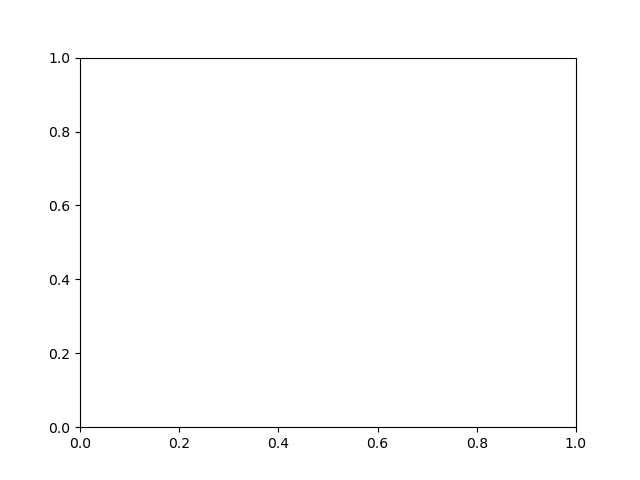

In [18]:
fig, ax = plt.subplots()

c = c_of_y(u.sub(0), ufl.exp)
mu = u.sub(1).eval(points_on_proc, cells)

W = V.sub(1).collapse()[0]

c = ufl.variable(c)
dFdc = ufl.diff(free_energy(c, ufl.ln, ufl.sin), c)

chem_pot = dfx.fem.Function(W)
chem_pot.interpolate(dfx.fem.Expression(dFdc, W.element.interpolation_points()))
chem_pot = chem_pot.eval(points_on_proc, cells)

ax.plot(x, mu)
ax.plot(x, chem_pot)

plt.show()

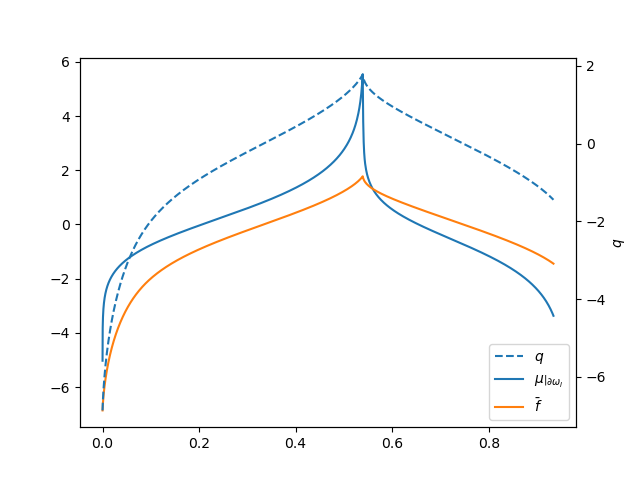

In [ ]:
q, f_bar, mu = np.array(rt_analysis.data).T
t = rt_analysis.t

fig, ax = plt.subplots()

ax1 = ax.twinx()

(p1,) = ax1.plot(t, q, '--', label=r"$q$")
ax1.set_ylabel(r"$q$")

(p2,) = ax.plot(t, mu, label=r"$\left. \mu \right|_{\partial \omega_I}$")
(p3,) = ax.plot(t, f_bar, label=r"$\bar f$")

labs = [l.get_label() for l in [p1, p2, p3]]

ax.legend([p1, p2, p3], labs, loc="lower right")

plt.show()

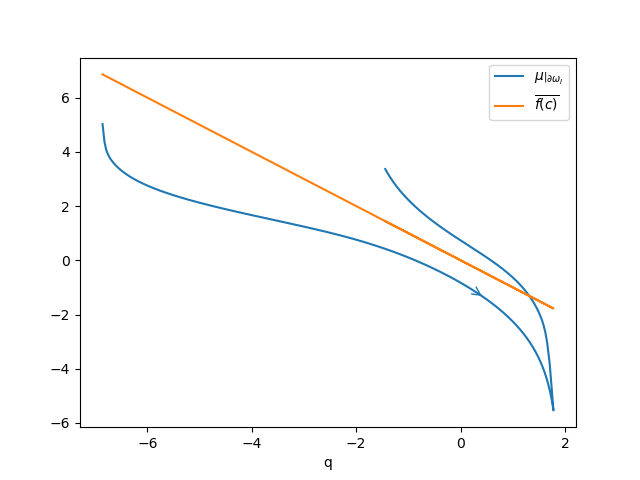

In [ ]:
fig, ax = plt.subplots()

line_mu, = ax.plot(q, -mu, label=r"$\left. \mu \right|_{\partial \omega_I}$")
line_f, = ax.plot(q, -f_bar, label=r"$\overline{f(c)}$")

ax.set_xlabel(r"q")

ax.legend()

add_arrow(line_mu, position=0.4002)

plt.show()